In [ ]:
import io
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import pandas as pd

# Load the data
try:
    returns_df = pd.read_csv("returns.csv",delimiter=";")
except FileNotFoundError:
    print("Error: The file was not found.")
    exit()

In [20]:
# returns_df.drop(columns=['Unnamed: 9'], inplace=True)
# Assume the first column is the date and the rest are asset returns
returns = returns_df.iloc[:, 1:].copy() # Create a copy to avoid SettingWithCopyWarning
# Replace commas with periods and convert to float64
for col in returns.columns:
    returns.loc[:, col] = returns.loc[:, col].astype(str).str.replace(',', '.')
returns = returns.apply(pd.to_numeric, errors='coerce')

annual_risk_free_rate = 0.05

In [21]:
returns

,PETR4 BZ Equity,VALE3 BZ Equity,ITUB4 BZ Equity,BBDC4 BZ Equity,SUZB3 BZ Equity,CYRE3 BZ Equity,EMBR3 BZ Equity,SOMA3 BZ Equity,SMFT3 BZ Equity,JBSS3 BZ Equity,GGBR4 BZ Equity,CPLE6 BZ Equity,RENT3 BZ Equity,IBOV Index
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.041939,-0.078949,0.009451,-0.009285,0.017431,0.039141,0.000895,0.085293,0.009565,-0.010823,-0.040258,0.023257,0.057972,0.000625
2,-0.032169,-0.011437,-0.054204,-0.068454,-0.009488,-0.022082,-0.029053,0.002025,-0.001429,0.030013,-0.000789,-0.018228,-0.000834,-0.021096
3,-0.005786,-0.030114,-0.012163,0.048191,0.001014,0.054637,0.062492,-0.002701,-0.012470,0.023223,-0.040797,-0.003350,0.037226,0.013563
4,0.010391,0.053008,-0.005259,-0.023270,0.005456,-0.044539,-0.010002,-0.013615,-0.019986,-0.021114,-0.029370,0.000000,-0.032481,-0.000411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,0.006940,0.033438,-0.011268,-0.014628,0.027493,-0.023366,0.000807,0.000000,-0.018519,-0.003748,0.003899,-0.005115,-0.032001,-0.001336
779,-0.001661,0.018458,0.012108,0.017923,0.008439,0.002833,-0.012589,0.000000,0.008376,0.041030,0.015992,0.002049,0.005916,0.010105
780,-0.002219,-0.003505,-0.010692,-0.014579,0.001008,0.000943,0.023825,0.000000,-0.005110,0.009107,0.010882,0.011196,-0.005442,-0.003685
781,-0.004453,-0.003037,-0.002833,0.003332,0.013839,0.029701,-0.020969,0.000000,0.027563,0.008208,-0.003252,-0.003041,0.011324,-0.000693


In [22]:
returns.mean()

,0
PETR4 BZ Equity,0.000318
VALE3 BZ Equity,-0.000195
ITUB4 BZ Equity,0.000471
BBDC4 BZ Equity,-0.000338
SUZB3 BZ Equity,0.000256
CYRE3 BZ Equity,0.000515
EMBR3 BZ Equity,0.000990
SOMA3 BZ Equity,-0.001057
SMFT3 BZ Equity,0.000062
JBSS3 BZ Equity,-0.000040


In [23]:
# Define a function to calculate the Sharpe Ratio (to be minimized)
def neg_sharpe_ratio(weights, returns, risk_free_rate):
    portfolio_return = np.sum(returns.mean() * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights))) # Annualize std dev
    sharpe = (portfolio_return - risk_free_rate) / portfolio_std_dev # Annualize risk_free_rate for calculation
    return -sharpe # We want to minimize the negative Sharpe Ratio

# Define constraints and bounds for optimization
num_assets = returns.shape[1]
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}) # Weights must sum to 1
bounds = tuple((0, 1) for asset in range(num_assets)) # Weights must be between 0 and 1

# Initial guess for weights (equal weighting)
initial_weights = np.array(num_assets * [1. / num_assets,])

# Perform optimization
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(returns, annual_risk_free_rate),
                             method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimized weights and calculate portfolio performance metrics
optimal_weights = optimized_results.x
optimal_portfolio_return = np.sum(returns.mean() * optimal_weights) * 252
optimal_portfolio_std_dev = np.sqrt(np.dot(optimal_weights.T, np.dot(returns.cov() * 252, optimal_weights)))
max_sharpe_ratio = (optimal_portfolio_return - annual_risk_free_rate) / optimal_portfolio_std_dev

# Display the results
print("Optimal Weights:")
for i, asset in enumerate(returns.columns):
    print(f"{asset}: {optimal_weights[i]:.4f}")

print(f"\nOptimal Portfolio Annual Return: {optimal_portfolio_return:.4f}")
print(f"Optimal Portfolio Annual Standard Deviation: {optimal_portfolio_std_dev:.4f}")
print(f"Maximum Sharpe Ratio: {max_sharpe_ratio:.4f}")

Optimal Weights:
PETR4 BZ Equity: 0.0000
VALE3 BZ Equity: 0.0000
ITUB4 BZ Equity: 0.0000
BBDC4 BZ Equity: 0.0000
SUZB3 BZ Equity: 0.0000
CYRE3 BZ Equity: 0.0000
EMBR3 BZ Equity: 0.0000
SOMA3 BZ Equity: 1.0000
SMFT3 BZ Equity: 0.0000
JBSS3 BZ Equity: 0.0000
GGBR4 BZ Equity: 0.0000
CPLE6 BZ Equity: 0.0000
RENT3 BZ Equity: 0.0000
IBOV Index: 0.0000

Optimal Portfolio Annual Return: -0.2664
Optimal Portfolio Annual Standard Deviation: 0.4686
Maximum Sharpe Ratio: -0.6752


In [24]:
returns_df.shape

(783, 15)

In [25]:
returns_df.head()

,Dates,PETR4 BZ Equity,VALE3 BZ Equity,ITUB4 BZ Equity,BBDC4 BZ Equity,SUZB3 BZ Equity,CYRE3 BZ Equity,EMBR3 BZ Equity,SOMA3 BZ Equity,SMFT3 BZ Equity,JBSS3 BZ Equity,GGBR4 BZ Equity,CPLE6 BZ Equity,RENT3 BZ Equity,IBOV Index
0,02/11/2021,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,03/11/2021,"-0,041938689","-0,078948635","0,009451478","-0,009285417","0,017430518","0,039141299","0,000895255","0,085292953","0,009564874","-0,010822616","-0,040257677","0,023256862","0,057971702","0,000625285"
2,04/11/2021,"-0,032169283","-0,011437295","-0,054203563","-0,068453788","-0,009488312","-0,022081861","-0,029053337","0,002024975","-0,001428912","0,030012971","-0,000789344","-0,018227514","-0,00083415","-0,021096327"
3,05/11/2021,"-0,005785937","-0,030114428","-0,012163486","0,048190553","0,001013685","0,054636819","0,06249244","-0,002700879","-0,012470186","0,023223483","-0,040797318","-0,003350087","0,037226361","0,013563068"
4,08/11/2021,"0,010390703","0,053007625","-0,005258557","-0,02326981","0,005456212","-0,044539123","-0,010002258","-0,013614914","-0,019986042","-0,021113778","-0,02937015",0,"-0,032480999","-0,000411249"


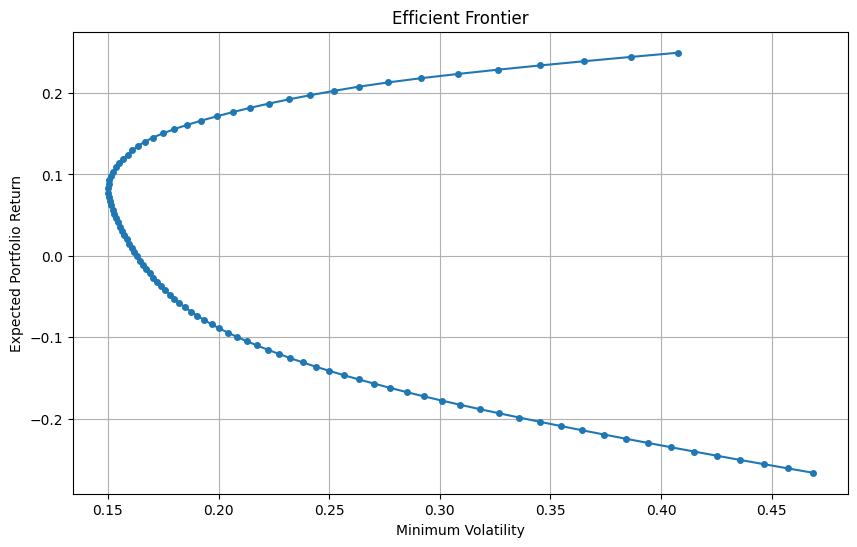

In [26]:
import matplotlib.pyplot as plt

# Calculate expected returns and covariance matrix
expected_returns = returns.mean() * 252  # Annualize returns
covariance_matrix = returns.cov() * 252  # Annualize covariance

# Define a function to calculate portfolio volatility
def portfolio_volatility(weights, covariance_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

# Define a function to minimize volatility for a given target return
def minimize_volatility(target_return, expected_returns, covariance_matrix):
    num_assets = len(expected_returns)
    initial_weights = np.array(num_assets * [1. / num_assets,])

    # Constraints: weights sum to 1, and portfolio return equals target return
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: np.sum(weights * expected_returns) - target_return}
    )

    # Bounds: weights must be between 0 and 1
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Minimize volatility
    result = minimize(portfolio_volatility, initial_weights, args=(covariance_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result.fun # Return the minimum volatility

# Generate a range of target returns
min_return = expected_returns.min()
max_return = expected_returns.max()
target_returns = np.linspace(min_return, max_return, 100)

# Calculate minimum volatility for each target return
min_volatilities = []
for tr in target_returns:
    min_vol = minimize_volatility(tr, expected_returns, covariance_matrix)
    min_volatilities.append(min_vol)

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(min_volatilities, target_returns, linestyle='-', marker='o', markersize=4)
plt.xlabel('Minimum Volatility')
plt.ylabel('Expected Portfolio Return')
plt.title('Efficient Frontier')
plt.grid(True)
plt.show()

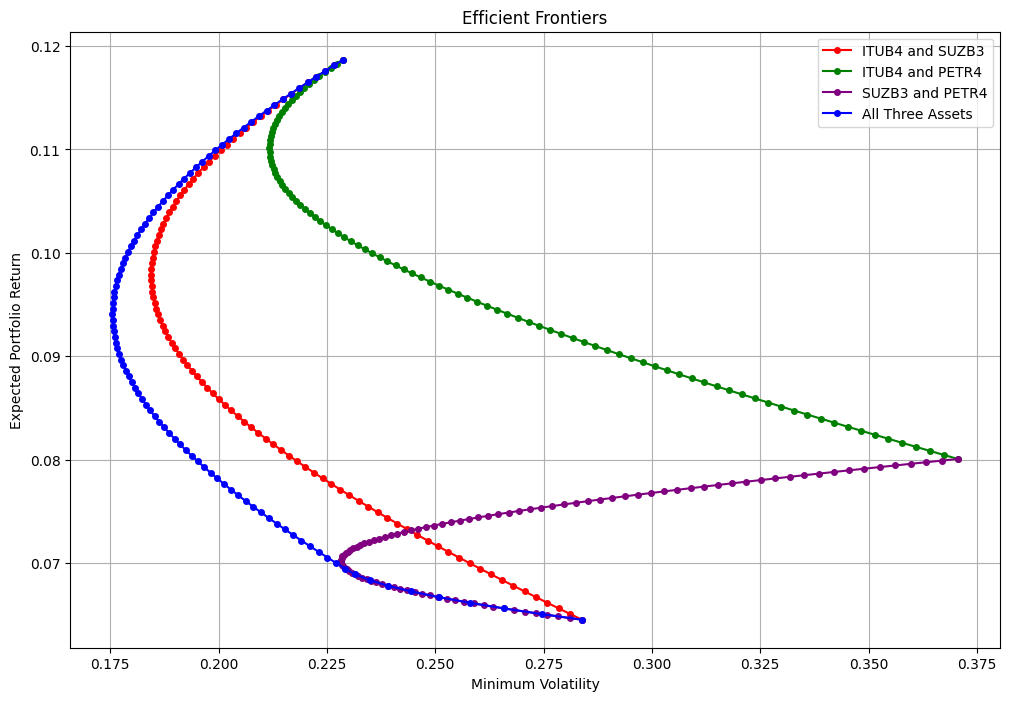

In [27]:
# Create a filtered DataFrame with the desired assets
selected_assets = ['ITUB4 BZ Equity', 'SUZB3 BZ Equity', 'PETR4 BZ Equity']
filtered_returns = returns[selected_assets].copy()

# Calculate expected returns and covariance matrix for the filtered data
filtered_expected_returns = filtered_returns.mean() * 252
filtered_covariance_matrix = filtered_returns.cov() * 252

# Function to plot efficient frontier for a given set of returns
def plot_efficient_frontier(returns_df, label, color):
    expected_returns = returns_df.mean() * 252
    covariance_matrix = returns_df.cov() * 252

    min_return = expected_returns.min()
    max_return = expected_returns.max()
    target_returns = np.linspace(min_return, max_return, 100)

    min_volatilities = []
    for tr in target_returns:
        min_vol = minimize_volatility(tr, expected_returns, covariance_matrix)
        min_volatilities.append(min_vol)

    plt.plot(min_volatilities, target_returns, linestyle='-', marker='o', markersize=4, label=label, color=color)

# Plot efficient frontier for each pair of assets
plt.figure(figsize=(12, 8))
plot_efficient_frontier(filtered_returns[['ITUB4 BZ Equity', 'SUZB3 BZ Equity']], 'ITUB4 and SUZB3', 'red')
plot_efficient_frontier(filtered_returns[['ITUB4 BZ Equity', 'PETR4 BZ Equity']], 'ITUB4 and PETR4', 'green')
plot_efficient_frontier(filtered_returns[['SUZB3 BZ Equity', 'PETR4 BZ Equity']], 'SUZB3 and PETR4', 'purple')

# Plot efficient frontier for all three assets
plot_efficient_frontier(filtered_returns, 'All Three Assets', 'blue')

plt.xlabel('Minimum Volatility')
plt.ylabel('Expected Portfolio Return')
plt.title('Efficient Frontiers')
plt.legend()
plt.grid(True)
plt.show()